# CNN_3channel_ResNet

Abstract:
- CNN
- ResNet

Result:
- 

References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl

## 1. Preprocess

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'CNN_3channel_ResNet'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

run_name: SC_Iceberg_Classifier_CNN_3channel_ResNet_20171108_130111


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\input
log_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log
model_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\model
output_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output


### Unzip files

In [5]:
# with lzma.open("train.json.7z") as f:
#     file_content = f.read()

In [6]:
# Unzip(input_path, os.path.join(input_path, 'sample_submission.csv.7z'))
# Unzip(input_path, os.path.join(input_path, 'test.json.7z'))
# Unzip(input_path, os.path.join(input_path, 'train.json.7z'))

### Load data

In [7]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [8]:
%%time
#Load data
data_path = os.path.join(input_path, 'train.json')
test_path = os.path.join(input_path, 'test.json')
pd_data = pd.read_json(data_path)
pd_test = pd.read_json(test_path)
print(pd_data.shape)
print(pd_test.shape)

(1604, 5)
(8424, 4)
Wall time: 19.2 s


In [9]:
#get numpy arrays for train/test data, prob there is a more pythonic approach
band1 = pd_data['band_1'].values
im1 = np.zeros((len(band1),len(band1[0])))
for j in range(len(band1)):
    im1[j,:]=np.asarray(band1[j])
    
band2 = pd_data['band_2'].values
im2 = np.zeros((len(band2),len(band2[0])))
for j in range(len(band2)):
    im2[j,:]=np.asarray(band2[j])
    
#get numpy array for test data
band1test = pd_test['band_1'].values
im1test = np.zeros((len(band1test),len(band1test[0])))
for j in range(len(band1test)):
    im1test[j,:]=np.asarray(band1test[j])
    
band2test = pd_test['band_2'].values
im2test = np.zeros((len(band2test),len(band2test[0])))
for j in range(len(band2test)):
    im2test[j,:]=np.asarray(band2test[j])

In [10]:
print(pd_data['id'].values.shape)
print(pd_data['band_1'].values.shape)
print(pd_data['band_2'].values.shape)
print(pd_data['inc_angle'].values.shape)
print(pd_data['is_iceberg'].values.shape)

(1604,)
(1604,)
(1604,)
(1604,)
(1604,)


In [11]:
id_data = pd_data['id'].as_matrix()
id_test = pd_test['id'].as_matrix()
print(id_data.shape)
print(id_test.shape)

(1604,)
(8424,)


In [12]:
inc_angle_data = pd_data['inc_angle'].replace('na', 0).astype(float).fillna(0.0)
inc_angle_test = pd_test['inc_angle'].replace('na', 0).astype(float).fillna(0.0)
print(inc_angle_data.shape)
print(inc_angle_test.shape)

(1604,)
(8424,)


In [13]:
y_data = pd_data['is_iceberg']
print(y_data.shape)

(1604,)


In [14]:
band1_data = im1.reshape(-1, 75,75)
band2_data = im2.reshape(-1, 75,75)

band1_test = im1test.reshape(-1, 75,75)
band2_test = im2test.reshape(-1, 75,75)

print(band1_data.shape)
print(band2_data.shape)
print(band1_test.shape)
print(band2_test.shape)

(1604, 75, 75)
(1604, 75, 75)
(8424, 75, 75)
(8424, 75, 75)


In [15]:
band_avg_data = (band1_data + band2_data)/2
print(band_avg_data.shape)
band_avg_test = (band1_test + band2_test)/2
print(band_avg_test.shape)

(1604, 75, 75)
(8424, 75, 75)


(75, 75)


Text(0.5,1,'5941774d')

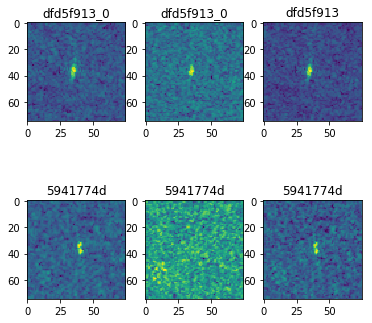

In [16]:
# Preview images
print(band1_data[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_data[0].reshape(75, 75))
ax[0, 0].set_title(id_data[0] + '_' + str(y_data[0]))
ax[0, 1].imshow(band2_data[0].reshape(75, 75))
ax[0, 1].set_title(id_data[0] + '_' + str(y_data[1]))
ax[0, 2].imshow(band_avg_data[0].reshape(75, 75))
ax[0, 2].set_title(id_data[0])

ax[1, 0].imshow(band1_test[0].reshape(75, 75))
ax[1, 0].set_title(id_test[0])
ax[1, 1].imshow(band2_test[0].reshape(75, 75))
ax[1, 1].set_title(id_test[0])
ax[1, 2].imshow(band_avg_test[0].reshape(75, 75))
ax[1, 2].set_title(id_test[0])

**train_test_split**

In [17]:
x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
                         band2_data[:, :, :, np.newaxis],
                         band_avg_data[:, :, :, np.newaxis]], axis=-1)
print(x_data.shape)
x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
                         band2_test[:, :, :, np.newaxis],
                         band_avg_test[:, :, :, np.newaxis]], axis=-1)
print(x_test.shape)

(1604, 75, 75, 3)
(8424, 75, 75, 3)


In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.15, shuffle=True, random_state=31)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(1363, 75, 75, 3)
(241, 75, 75, 3)
(1363,)
(241,)


## 2. Build model

In [19]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, Input, Add
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [20]:
def build_model():
    bn_model = 0
    p_activation = "relu"
    input_1 = Input(shape=(75, 75, 3), name="bands")
    input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation, padding='same')(input_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.5)(img_1)
    
    shortcut = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Add()([img_1, shortcut])
    shortcut = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Add()([img_1, shortcut])
    shortcut = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Add()([img_1, shortcut])
    shortcut = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Add()([img_1, shortcut])
    shortcut = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Add()([img_1, shortcut])
    shortcut = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Add()([img_1, shortcut])
    shortcut = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Add()([img_1, shortcut])
    shortcut = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Add()([img_1, shortcut])
    shortcut = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Add()([img_1, shortcut])
    shortcut = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Add()([img_1, shortcut])
    shortcut = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = Add()([img_1, shortcut])
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.5)(img_1)
    
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation, padding='same') (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.5)(img_1)

    img_1 = GlobalMaxPooling2D() (img_1)

    dense_ayer = Dense(1024, activation=p_activation)(img_1)
    dense_ayer = BatchNormalization()(dense_ayer)
    dense_ayer = Dropout(0.5)(dense_ayer)
    dense_ayer = Dense(1024, activation=p_activation)(dense_ayer)
    dense_ayer = BatchNormalization()(dense_ayer)
    dense_ayer = Dropout(0.5)(dense_ayer)
    output = Dense(1, activation="sigmoid")(dense_ayer)
    
    model = Model(input_1, output)
#     optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [21]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bands (InputLayer)              (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 75, 32)   896         bands[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 75, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 75, 75, 32)   9248        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [22]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
saveModel(model, 'saveModel_test')

In [23]:
def get_lr(x):
    lr = round(1e-4 * 0.98 ** x, 6)
    if lr < 5e-5:
        lr = 5e-5
    print(lr, end='  ')
    return lr

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log\SC_Iceberg_Classifier_CNN_3channel_ResNet_20171108_130111


In [24]:
datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=False,
    vertical_flip=False)

batch_size = 8
steps_per_epoch=int(len(x_train) / batch_size)
print(steps_per_epoch)

170


In [25]:
# hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size, shuffle = True, seed=2017),
#                            steps_per_epoch = steps_per_epoch, 
#                            epochs = 100, #1 for ETA, 0 for silent
#                            verbose = 1,
#                            max_queue_size = 16, 
#                            workers = 8,
#                            validation_data =(x_val, y_val),
#                            callbacks = [annealer, tensorBoard])

In [26]:
%%time
hist = model.fit(x_train, y_train, 
                 batch_size = 8, 
                 verbose= 1,
                 epochs = 100, #1 for ETA, 0 for silent
                 validation_data=(x_val, y_val),
                 callbacks=[annealer, tensorBoard])

Train on 1363 samples, validate on 241 samples
0.0001  Epoch 1/100
1363/1363 [==============================] - 103s 75ms/step - loss: 0.9256 - acc: 0.5664 - val_loss: 0.7663 - val_acc: 0.4357
9.8e-05  Epoch 2/100
1363/1363 [==============================] - 100s 73ms/step - loss: 0.8903 - acc: 0.5752 - val_loss: 0.7555 - val_acc: 0.4149
9.6e-05  Epoch 3/100
1363/1363 [==============================] - 100s 74ms/step - loss: 0.8069 - acc: 0.6023 - val_loss: 0.6803 - val_acc: 0.6100
9.4e-05  Epoch 4/100
1363/1363 [==============================] - 101s 74ms/step - loss: 0.8719 - acc: 0.5737 - val_loss: 0.9346 - val_acc: 0.4357
9.2e-05  Epoch 5/100
1363/1363 [==============================] - 100s 74ms/step - loss: 0.8375 - acc: 0.5906 - val_loss: 1.4921 - val_acc: 0.4357
9e-05  Epoch 6/100
1363/1363 [==============================] - 101s 74ms/step - loss: 0.8358 - acc: 0.5759 - val_loss: 0.7931 - val_acc: 0.5311
8.9e-05  Epoch 7/100
1363/1363 [==============================] - 101s 74m

1363/1363 [==============================] - 101s 74ms/step - loss: 0.3712 - acc: 0.8401 - val_loss: 0.6193 - val_acc: 0.6888
5e-05  Epoch 57/100
1363/1363 [==============================] - 101s 74ms/step - loss: 0.3894 - acc: 0.8247 - val_loss: 0.5433 - val_acc: 0.7510
5e-05  Epoch 58/100
1363/1363 [==============================] - 101s 74ms/step - loss: 0.3600 - acc: 0.8489 - val_loss: 0.4706 - val_acc: 0.8050
5e-05  Epoch 59/100
1363/1363 [==============================] - 101s 74ms/step - loss: 0.3804 - acc: 0.8525 - val_loss: 0.7449 - val_acc: 0.6722
5e-05  Epoch 60/100
1363/1363 [==============================] - 101s 74ms/step - loss: 0.3528 - acc: 0.8496 - val_loss: 0.4805 - val_acc: 0.8216
5e-05  Epoch 61/100
1363/1363 [==============================] - 101s 74ms/step - loss: 0.3969 - acc: 0.8210 - val_loss: 0.7594 - val_acc: 0.6307
5e-05  Epoch 62/100
1363/1363 [==============================] - 101s 74ms/step - loss: 0.3694 - acc: 0.8459 - val_loss: 1.0160 - val_acc: 0.560

In [27]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

241/241 [==============================] - 6s 25ms/step
Final loss: 0.6706, final accuracy: 0.7593


In [28]:
val_prob1 = model.predict(x_val)

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob1_limit = np.clip(val_prob1, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

val_prob1_limit = np.clip(val_prob1_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

Val log_loss: 0.6706408442013039
Val log_loss: 0.5617150241254029


In [29]:
final_acc_str = str(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_ResNet_20171108_130111_5617


In [30]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


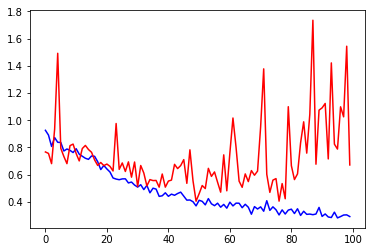

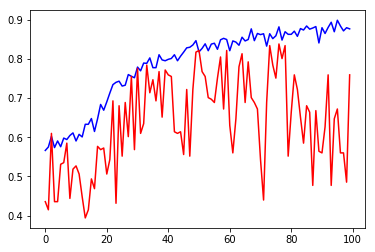

In [31]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [32]:
saveModel(model, run_name_acc)

## 3. Predict

In [33]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output\SC_Iceberg_Classifier_CNN_3channel_ResNet_20171108_130111_5617.csv


In [34]:
test_prob = model.predict(x_test)
print(test_prob.shape)
print(test_prob[0:2])
test_prob = np.clip(test_prob, 0.05, 0.95)
print(test_prob.shape)
print(test_prob[0:2])

(8424, 1)
[[ 0.84966427]
 [ 0.42031235]]
(8424, 1)
[[ 0.84966427]
 [ 0.42031235]]


In [35]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

         id  is_iceberg
0  5941774d    0.849664
1  4023181e    0.420312
(8424, 2)


In [36]:
print(run_name_acc)
print('Done!')

SC_Iceberg_Classifier_CNN_3channel_ResNet_20171108_130111_5617
Done!
